In [1]:
from keras.datasets import reuters
from keras.models import *
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
word_dim = 10000
label_dim = 46

In [3]:
def vectorize_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [4]:
def to_one_hot(labels, dimension):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [5]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=word_dim)
x_train = vectorize_sequences(x_train, word_dim)
y_train = to_one_hot(y_train, label_dim)
x_test = vectorize_sequences(x_test, word_dim)
y_test = to_one_hot(y_test, label_dim)
print(x_train.shape, len(x_train), y_train.shape, len(y_train))
print(x_test.shape, len(x_test), y_test.shape, len(y_test))

(8982, 10000) 8982 (8982, 46) 8982
(2246, 10000) 2246 (2246, 46) 2246


In [6]:
def build_model(word_dimension, label_dimension):
    network = Sequential()
    network.add(Dense(128, activation='relu', input_shape = (word_dimension,)))
    network.add(Dense(128, activation='relu'))
    network.add(Dense(label_dimension, activation='softmax'))
    network.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'rmsprop',
        metrics = ['acc']
    )
    return network

In [7]:
def build_model_smaller(word_dimension, label_dimension):
    network = Sequential()
    network.add(Dense(16, activation='relu', input_shape = (word_dimension,)))
    network.add(Dense(16, activation='relu'))
    network.add(Dense(label_dimension, activation='softmax'))
    network.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'rmsprop',
        metrics = ['acc']
    )
    return network

In [8]:
def run_k_fold_validation(k, data, target, epoch_n, batch_n):
    val_samples = len(data) // k
    
    all_history = []
    for fold in range(k):
        print("Processing fold number : ", fold)
        val_start = fold * val_samples
        val_end = (fold + 1) * val_samples
        
        val_data = data[val_start: val_end]
        val_target = target[val_start: val_end]
        train_data = np.concatenate([data[:val_start], data[val_end:]], axis = 0)
        train_target = np.concatenate([target[:val_start], target[val_end:]], axis = 0)
        
        network = build_model(data.shape[1], target.shape[1])
        history = network.fit(
            train_data, train_target,
            validation_data = (val_data, val_target),
            epochs = epoch_n,
            batch_size = batch_n,
            verbose = 0
        )
        
        all_history.append(history)
        print("End of process number : ", fold)
        
    all_val_loss = []
    all_loss = []
    all_val_acc = []
    all_acc = []
    
    for his in all_history:
        all_val_loss.append(his.history['val_loss'])
        all_val_acc.append(his.history['val_acc'])
        all_loss.append(his.history['loss'])
        all_acc.append(his.history['acc'])
        
    his_dic = {
        'val_loss': [np.mean([his[i] for his in all_val_loss]) for i in range(epoch_n)],
        'val_acc': [np.mean([his[i] for his in all_val_acc]) for i in range(epoch_n)],
        'loss': [np.mean([his[i] for his in all_loss]) for i in range(epoch_n)],
        'acc': [np.mean([his[i] for his in all_acc]) for i in range(epoch_n)]
    }
    
    return his_dic

In [9]:
history_dict = run_k_fold_validation(10, x_train, y_train, 10, 512)

Processing fold number :  0
End of process number :  0
Processing fold number :  1
End of process number :  1
Processing fold number :  2
End of process number :  2
Processing fold number :  3
End of process number :  3
Processing fold number :  4
End of process number :  4
Processing fold number :  5
End of process number :  5
Processing fold number :  6
End of process number :  6
Processing fold number :  7
End of process number :  7
Processing fold number :  8
End of process number :  8
Processing fold number :  9
End of process number :  9


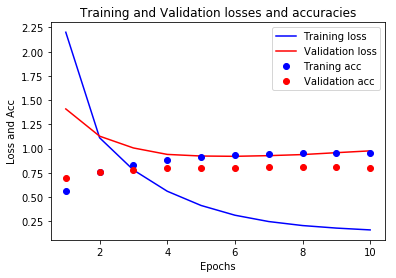

In [10]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss) + 1)
plt.clf()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.plot(epochs, acc, 'bo', label = 'Traning acc')
plt.plot(epochs, val_acc, 'ro', label = 'Validation acc')
plt.title('Training and Validation losses and accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss and Acc')
plt.legend()

plt.show()

In [12]:
# overfitting, underfitting
origin_history = build_model(x_train.shape[1], y_train.shape[1]).fit(
    x_train[1000:], y_train[1000:],
    epochs = 30,
    batch_size = 512,
    validation_data=(x_train[:1000], y_train[:1000]),
    verbose = 1
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/30
7982/7982 [==============================] - 2s 266us/step - loss: 2.2532 - acc: 0.5489 - val_loss: 1.4111 - val_acc: 0.7080
Epoch 2/30
7982/7982 [==============================] - 2s 201us/step - loss: 1.1289 - acc: 0.7572 - val_loss: 1.0997 - val_acc: 0.7720
Epoch 3/30
7982/7982 [==============================] - 2s 201us/step - loss: 0.8001 - acc: 0.8295 - val_loss: 0.9889 - val_acc: 0.8010
Epoch 4/30
7982/7982 [==============================] - 2s 202us/step - loss: 0.5682 - acc: 0.8827 - val_loss: 0.9245 - val_acc: 0.8050
Epoch 5/30
7982/7982 [==============================] - 2s 208us/step - loss: 0.4324 - acc: 0.9082 - val_loss: 0.8687 - val_acc: 0.8320
Epoch 6/30
7982/7982 [==============================] - 2s 204us/step - loss: 0.3204 - acc: 0.9308 - val_loss: 0.9010 - val_acc: 0.8140
Epoch 7/30
7982/7982 [==============================] - 2s 205us/step - loss: 0.2620 - acc: 0.9396 - val_loss: 0.8948 - val_acc: 0.8220


In [13]:
smaller_history = build_model_smaller(x_train.shape[1], y_train.shape[1]).fit(
        x_train[1000:], y_train[1000:],
    epochs = 30,
    batch_size = 512,
    validation_data=(x_train[:1000], y_train[:1000]),
    verbose = 1
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/30
7982/7982 [==============================] - 1s 179us/step - loss: 3.4373 - acc: 0.2486 - val_loss: 3.0681 - val_acc: 0.4650
Epoch 2/30
7982/7982 [==============================] - 1s 130us/step - loss: 2.7928 - acc: 0.5008 - val_loss: 2.5311 - val_acc: 0.5490
Epoch 3/30
7982/7982 [==============================] - 1s 132us/step - loss: 2.2862 - acc: 0.5775 - val_loss: 2.1153 - val_acc: 0.5980
Epoch 4/30
7982/7982 [==============================] - 1s 141us/step - loss: 1.9061 - acc: 0.6282 - val_loss: 1.8220 - val_acc: 0.6210
Epoch 5/30
7982/7982 [==============================] - 1s 128us/step - loss: 1.6387 - acc: 0.6604 - val_loss: 1.6185 - val_acc: 0.6430
Epoch 6/30
7982/7982 [==============================] - 1s 129us/step - loss: 1.4430 - acc: 0.6809 - val_loss: 1.4842 - val_acc: 0.6620
Epoch 7/30
7982/7982 [==============================] - 1s 127us/step - loss: 1.2866 - acc: 0.7130 - val_loss: 1.3664 - val_acc: 0.6950


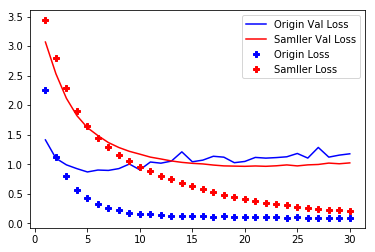

In [14]:
plt.clf()

plt.plot(range(1, 30 + 1), origin_history.history['val_loss'], 'b', label = 'Origin Val Loss')
plt.plot(range(1, 30 + 1), smaller_history.history['val_loss'], 'r', label = 'Samller Val Loss')
plt.plot(range(1, 30 + 1), origin_history.history['loss'], 'bP', label = 'Origin Loss')
plt.plot(range(1, 30 + 1), smaller_history.history['loss'], 'rP', label = 'Samller Loss')
plt.legend()

plt.show()

In [ ]:
# network.evaluate(x_test, y_test)

In [ ]:
# predictions = network.predict(x_test)
# np.argmax(predictions[0])